# Creating New Data

**Author: Nagdev Amruthnath**  
Most of us have come across situations where we have not enough data for building reliable models due to various reasons such as its expensive to collect data (human studies), limited resources, lack of historical data availability (earth quakes). Even before we begin talking about how to overcome the challange, let me first talk about why we need minimum samples even before we consider building model. First of all we can build a model with low samples. It is defnitly possible! But, the as the number of samples decreases, the margin of error increases and vice versa. If you want to build a model with the highest accuracy you would need a as many samples as possible. There is a formula that can be used to calculate the sample size and is as follows   

![Image](https://www.dummies.com/wp-content/uploads/359816.image0.png)  

Where, n = sample size
       Z = Z-score value
       σ = populated standard deviation
       MOE = acceptable margin of error

You can also calulated with an online calculator as in this link   
https://www.qualtrics.com/blog/calculating-sample-size/  

Now we know that why minimum samples are required for achieveing required accuracy, say in same case we do not have an opportunity to collect more samples or available. They we have an option to do the following    
1. K-fold cross validation  
2. Leave-P-out cross validation  
3. Leave-one-out cross validation  
4. New data creation through estimation  

In K-fold method, the data is split into k partitions and then is trained with each partition and tested with the leftout kth partition. In k-hold method, not all combinations are considered. Only user specified partions are considered. While in leave-one/p-out, all combinations or partitions are cosidered. This is more exhasustive technique in validating the results. The following above two techniques are the most popular techniques that is used both in machine learning and deep learning. 

In new data creation through estimation technique, rows of missing data is created in the data set and a seperate data imputation model is used to impute missing data in the rows. Multivariate Imputation by Chained Equations (MICE) is one of the most popular algorthims that are available to insert missing data irrespective of data types such as mixes of continuous, binary, unordered categorical and ordered categorical data.

There are various tutorials available for k-fold and leave one out models. This tutorial will focus on the fourth model where new data will be created to handle less sample size. In the and a simple classification model with be trained to see if there was a significant imporvement. Also, distribution of imputed and non-imputed data will be compared to see any signifcant difference. 



In [1]:
options(warn=-1)

# load libraies
library(mice)
library(dplyr)

Loading required package: lattice

Attaching package: 'mice'

The following objects are masked from 'package:base':

    cbind, rbind


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



## Load data into a dataframe
The data availabe in the repository is used for the analysis

In [2]:
setwd("C:/Users/aanamruthn/Documents/Jupyter/Testing/RNotebooksTesting/OpenSourceWork/Experiment")
#read csv files
file1 = read.csv("dry run.csv", sep=",", header =T)
file2 = read.csv("base.csv", sep=",", header =T)
file3 = read.csv("imbalance 1.csv", sep=",", header =T)
file4 = read.csv("imbalance 2.csv", sep=",", header =T)

#Add labels to data
file1$y = 1
file2$y = 2
file3$y = 3
file4$y = 4

#view top rows of data
head(file1)

time,ax,ay,az,aT,y
0.002,-0.3246,0.2748,0.1502,0.451,1
0.009,0.6020,-0.1900,-0.3227,0.709,1
0.019,0.9787,0.3258,0.0124,1.032,1
0.027,0.6141,-0.4179,0.0471,0.744,1
0.038,-0.3218,-0.6389,-0.4259,0.833,1
0.047,-0.3607,0.1332,-0.1291,0.406,1


## Create some features from data
the data used in this study is vibration data with different states. The data was collected at 100Hz. The data to be used as is is high dimentional also, we do not have any good summary of the data. Hence, some statistical features are extracted. In this case, sample standard deviation, sample mean, sample min, sample max and sample median is calculated. Also, the  data is aggrigated by 1 second. 

In [3]:
file1$group = as.factor(round(file1$time))
file2$group = as.factor(round(file2$time))
file3$group = as.factor(round(file3$time))
file4$group = as.factor(round(file4$time))
#(file1,20)

#list of all files
files = list(file1, file2, file3, file4)

#loop through all files and combine
features = NULL
for (i in 1:4){
res = files[[i]] %>%
    group_by(group) %>%
    summarize(ax_mean = mean(ax),
              ax_sd = sd(ax),
              ax_min = min(ax),
              ax_max = max(ax),
              ax_median = median(ax),
              ay_mean = mean(ay),
              ay_sd = sd(ay),
              ay_min = min(ay),
              ay_may = max(ay),
              ay_median = median(ay),
              az_mean = mean(az),
              az_sd = sd(az),
              az_min = min(az),
              az_maz = max(az),
              az_median = median(az),
              aT_mean = mean(aT),
              aT_sd = sd(aT),
              aT_min = min(aT),
              aT_maT = max(aT),
              aT_median = median(aT),
              y = mean(y)
             )
    features = rbind(features, res)
}

features = subset(features, select = -group)

# store it in a df for future reference
actual.features = features

## Study data
First, lets look at the size of our populations and summary of our features along with thier data types. 

In [4]:
nrow(features)
str(features)

[1] 362

Classes 'tbl_df', 'tbl' and 'data.frame':	362 obs. of  21 variables:
 $ ax_mean  : num  -0.03816 -0.00581 0.06985 0.01155 0.04669 ...
 $ ax_sd    : num  0.659 0.633 0.667 0.551 0.643 ...
 $ ax_min   : num  -1.26 -1.62 -1.46 -1.93 -1.78 ...
 $ ax_max   : num  1.38 1.19 1.47 1.2 1.48 ...
 $ ax_median: num  -0.0955 -0.0015 0.107 0.0675 0.0836 ...
 $ ay_mean  : num  -0.068263 0.003791 0.074433 0.000826 -0.017759 ...
 $ ay_sd    : num  0.751 0.782 0.802 0.789 0.751 ...
 $ ay_min   : num  -1.39 -1.56 -1.48 -2 -1.66 ...
 $ ay_may   : num  1.64 1.54 1.8 1.56 1.44 ...
 $ ay_median: num  -0.19 0.0101 0.1186 -0.0027 -0.0253 ...
 $ az_mean  : num  -0.138 -0.205 -0.0641 -0.0929 -0.1399 ...
 $ az_sd    : num  0.985 0.925 0.929 0.889 0.927 ...
 $ az_min   : num  -2.68 -3.08 -1.82 -2.16 -1.85 ...
 $ az_maz   : num  2.75 2.72 2.49 3.24 3.55 ...
 $ az_median: num  0.0254 -0.2121 -0.1512 -0.1672 -0.1741 ...
 $ aT_mean  : num  1.27 1.26 1.3 1.2 1.23 ...
 $ aT_sd    : num  0.583 0.545 0.513 0.513 0.582 ...

## Create observations with NA values in the end

In [5]:
features1 = features
for(i in 363:400){
  features1[i,] = NA
}


## Look at bottom 50 rows

In [6]:
tail(features1, 50)

ax_mean,ax_sd,ax_min,ax_max,ax_median,ay_mean,ay_sd,ay_min,ay_may,ay_median,...,az_sd,az_min,az_maz,az_median,aT_mean,aT_sd,aT_min,aT_maT,aT_median,y
-0.016097030,0.8938523,-2.3445,2.3006,-0.07360,-0.009759406,1.311817,-3.4215,2.5028,0.10890,...,1.264572,-2.8751,3.3718,-0.07070,1.866030,0.7808319,0.380,4.098,1.8200,4
-0.015565347,0.8956615,-2.2661,2.5089,0.08640,0.027313861,1.294063,-2.9421,2.3497,0.15260,...,1.368576,-3.3165,2.6989,-0.01660,1.930426,0.7749686,0.127,4.463,1.8350,4
0.024006250,0.8653758,-2.4099,2.5328,-0.03170,0.008440625,1.376398,-3.0422,2.3727,0.11390,...,1.449783,-4.2171,4.7703,0.00110,2.003552,0.8300253,0.387,5.138,1.9920,4
-0.015563000,0.8720967,-2.3451,2.3269,-0.05325,0.013962000,1.240091,-3.1360,2.8563,0.09145,...,1.418988,-3.3758,3.4279,-0.10410,1.895380,0.8351505,0.173,4.458,1.8735,4
0.003894898,0.8806773,-2.3098,3.1902,-0.09260,0.022575510,1.301955,-3.2561,2.7833,-0.05380,...,1.271799,-3.8035,3.1323,-0.26115,1.852265,0.7909640,0.436,3.944,1.7570,4
-0.039379208,0.8127135,-2.1523,1.8828,-0.11250,0.005454455,1.189519,-2.8057,2.4852,0.03040,...,1.366368,-3.3928,2.4507,0.05430,1.828059,0.7562042,0.580,3.573,1.6960,4
0.021469000,0.8272527,-1.5895,3.7505,-0.08995,0.011312000,1.285206,-2.7423,2.6785,-0.03640,...,1.177012,-2.6649,2.1685,0.02755,1.785930,0.7120829,0.298,3.895,1.7575,4
0.005917000,0.9139808,-2.3310,2.8131,-0.07800,-0.040868000,1.320873,-2.9778,2.2841,-0.01435,...,1.401567,-3.3728,3.3165,0.19485,1.947570,0.8513573,0.397,4.191,1.8180,4
-0.034448571,0.8640626,-2.4917,2.4113,-0.01960,-0.013410476,1.235196,-3.3305,2.4912,0.09420,...,1.327886,-2.9864,2.8430,-0.05300,1.882590,0.6971337,0.370,3.775,1.9030,4
0.046837374,0.9776022,-1.8688,2.6644,-0.03600,0.019817172,1.293644,-2.7836,2.6166,0.12540,...,1.245906,-2.4813,3.2677,-0.11460,1.901646,0.7296095,0.283,3.813,1.8440,4


## Impute NA's with best values using iteration method

In [7]:
imputed_Data = mice(features1, 
                    m=1, 
                    maxit = 50, 
                    method = 'pmm', 
                    seed = 999, 
                    printFlag =FALSE)

## View imputed results

In [8]:
imputedResultData = mice::complete(imputed_Data,1)
tail(imputedResultData, 50)

,ax_mean,ax_sd,ax_min,ax_max,ax_median,ay_mean,ay_sd,ay_min,ay_may,ay_median,...,az_sd,az_min,az_maz,az_median,aT_mean,aT_sd,aT_min,aT_maT,aT_median,y
351,-0.016097030,0.8938523,-2.3445,2.3006,-0.07360,-0.009759406,1.3118166,-3.4215,2.5028,0.10890,...,1.2645719,-2.8751,3.3718,-0.07070,1.8660297,0.7808319,0.380,4.098,1.8200,4
352,-0.015565347,0.8956615,-2.2661,2.5089,0.08640,0.027313861,1.2940627,-2.9421,2.3497,0.15260,...,1.3685757,-3.3165,2.6989,-0.01660,1.9304257,0.7749686,0.127,4.463,1.8350,4
353,0.024006250,0.8653758,-2.4099,2.5328,-0.03170,0.008440625,1.3763983,-3.0422,2.3727,0.11390,...,1.4497833,-4.2171,4.7703,0.00110,2.0035521,0.8300253,0.387,5.138,1.9920,4
354,-0.015563000,0.8720967,-2.3451,2.3269,-0.05325,0.013962000,1.2400913,-3.1360,2.8563,0.09145,...,1.4189884,-3.3758,3.4279,-0.10410,1.8953800,0.8351505,0.173,4.458,1.8735,4
355,0.003894898,0.8806773,-2.3098,3.1902,-0.09260,0.022575510,1.3019546,-3.2561,2.7833,-0.05380,...,1.2717989,-3.8035,3.1323,-0.26115,1.8522653,0.7909640,0.436,3.944,1.7570,4
356,-0.039379208,0.8127135,-2.1523,1.8828,-0.11250,0.005454455,1.1895194,-2.8057,2.4852,0.03040,...,1.3663678,-3.3928,2.4507,0.05430,1.8280594,0.7562042,0.580,3.573,1.6960,4
357,0.021469000,0.8272527,-1.5895,3.7505,-0.08995,0.011312000,1.2852056,-2.7423,2.6785,-0.03640,...,1.1770121,-2.6649,2.1685,0.02755,1.7859300,0.7120829,0.298,3.895,1.7575,4
358,0.005917000,0.9139808,-2.3310,2.8131,-0.07800,-0.040868000,1.3208731,-2.9778,2.2841,-0.01435,...,1.4015674,-3.3728,3.3165,0.19485,1.9475700,0.8513573,0.397,4.191,1.8180,4
359,-0.034448571,0.8640626,-2.4917,2.4113,-0.01960,-0.013410476,1.2351957,-3.3305,2.4912,0.09420,...,1.3278861,-2.9864,2.8430,-0.05300,1.8825905,0.6971337,0.370,3.775,1.9030,4
360,0.046837374,0.9776022,-1.8688,2.6644,-0.03600,0.019817172,1.2936436,-2.7836,2.6166,0.12540,...,1.2459059,-2.4813,3.2677,-0.11460,1.9016465,0.7296095,0.283,3.813,1.8440,4


## Looking at distribution actual data and imputed data
We will first compare basic statistics and then distributions of the couple of features. In the comparison of statistics between actual and imputed we can observe that the mean and SD for both imputed and actual are almost equal.

In [9]:
data.frame(actual_ax_mean = c(mean(features$ax_mean), sd(features$ax_mean)) 
           , imputed_ax_mean = c(mean(imputedResultData$ax_mean), sd(imputedResultData$ax_mean))
           , actual_ax_median = c(mean(features$ax_median), sd(features$ax_median)) 
           , imputed_ax_median = c(mean(imputedResultData$ax_median), sd(imputedResultData$ax_median))
           , actual_az_sd = c(mean(features$az_sd), sd(features$az_sd)) 
           , imputed_az_sd = c(mean(imputedResultData$az_sd), sd(imputedResultData$az_sd))
           , row.names = c("mean", "sd"))

,actual_ax_mean,imputed_ax_mean,actual_ax_median,imputed_ax_median,actual_az_sd,imputed_az_sd
mean,0.006307909,0.005851233,-0.001328867,-0.00214025,1.0588650,1.0528059
sd,0.030961085,0.031125848,0.059619834,0.06011342,0.2446782,0.2477697


Now, lets look at the distributions in the data. From the distribution below, we can observe that the distributions for actual data and imputed data is almost identical. We can confirm it with the bandwidth in the plots

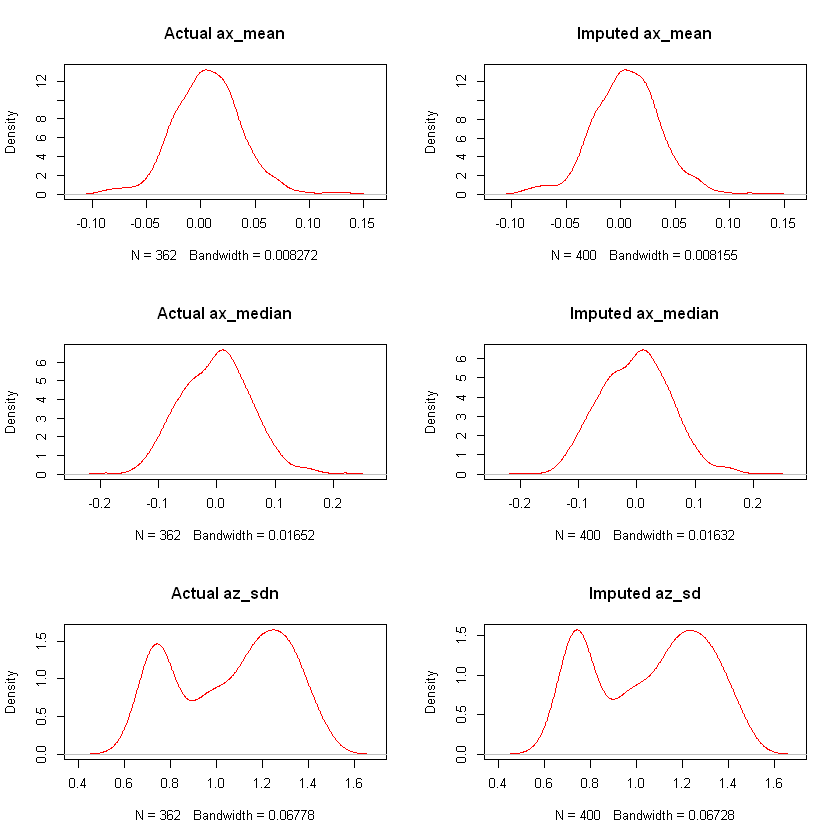

In [10]:
par(mfrow=c(3,2))
plot(density(features$ax_mean), main = "Actual ax_mean", type="l", col="red")
plot(density(imputedResultData$ax_mean), main = "Imputed ax_mean", type="l", col="red")
plot(density(features$ax_median), main = "Actual ax_median", type="l", col="red")
plot(density(imputedResultData$ax_median), main = "Imputed ax_median", type="l", col="red")
plot(density(features$az_sd), main = "Actual az_sdn", type="l", col="red")
plot(density(imputedResultData$az_sd), main = "Imputed az_sd", type="l", col="red")

## Building a classification model based on actual data and Imputed data

In the following data y will be our classification variable. We will build a classification model using basic support vector machine(SVM) with actual and imputed data. No transformation will be done on the data. In the end we will compare the results
### Actual Data
#### Sample data creation

In [11]:
#create samples of 80:20 ratio
features$y = as.factor(features$y)
sample = sample(nrow(features) , nrow(features)* 0.8)
train = features[sample,]
test = features[-sample,]

#### Build a SVM model

In [12]:
library(e1071)
library(caret)

actual.svm.model = svm(y ~., data = train)
summary(actual.svm.model)

Loading required package: ggplot2



Call:
svm(formula = y ~ ., data = train)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.05 

Number of Support Vectors:  142

 ( 47 18 47 30 )


Number of Classes:  4 

Levels: 
 1 2 3 4




#### Validate SVM model
In the below confusion matrix, we observe the following  
1. accuary>NIR indicating model is very good
2. Higher accuray and kappa value indicates a very accurate model
3. Even the balanced accuracy is close to 1 indicating the model is highly accurate

In [13]:
confusionMatrix(predict(actual.svm.model, test), test$y)

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 10  1  0  0
         2  0 26  0  0
         3  0  0 22  0
         4  0  0  3 11

Overall Statistics
                                          
               Accuracy : 0.9452          
                 95% CI : (0.8656, 0.9849)
    No Information Rate : 0.3699          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9234          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            1.0000   0.9630   0.8800   1.0000
Specificity            0.9841   1.0000   1.0000   0.9516
Pos Pred Value         0.9091   1.0000   1.0000   0.7857
Neg Pred Value         1.0000   0.9787   0.9412   1.0000
Prevalence             0.1370   0.3699   0.3425   0.1507
Detection Rate         0.1370   0.3562   0.3014   0.1507
Detection Prevalence   0.1507   0.3562   0.301

### Imputed Data
#### Sample data creation

In [14]:
#create samples of 80:20 ratio
imputedResultData$y = as.factor(imputedResultData$y)
sample = sample(nrow(imputedResultData) , nrow(imputedResultData)* 0.8)
train = imputedResultData[sample,]
test = imputedResultData[-sample,]

#### Build a SVM model

In [15]:
imputed.svm.model = svm(y ~., data = train)
summary(imputed.svm.model)


Call:
svm(formula = y ~ ., data = train)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.05 

Number of Support Vectors:  167

 ( 59 47 36 25 )


Number of Classes:  4 

Levels: 
 1 2 3 4




#### Validate SVM model
In the below confusion matrix, we observe the following  
1. accuary>NIR indicating model is very good
2. Higher accuray and kappa value indicates a very accurate model
3. Even the balanced accuracy is close to 1 indicating the model is highly accurate

In [16]:
confusionMatrix(predict(imputed.svm.model, test), test$y)

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 15  0  0  0
         2  1 21  0  0
         3  0  0 17  0
         4  0  0  0 26

Overall Statistics
                                          
               Accuracy : 0.9875          
                 95% CI : (0.9323, 0.9997)
    No Information Rate : 0.325           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9831          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9375   1.0000   1.0000    1.000
Specificity            1.0000   0.9831   1.0000    1.000
Pos Pred Value         1.0000   0.9545   1.0000    1.000
Neg Pred Value         0.9846   1.0000   1.0000    1.000
Prevalence             0.2000   0.2625   0.2125    0.325
Detection Rate         0.1875   0.2625   0.2125    0.325
Detection Prevalence   0.1875   0.2750   0.212

### Overall results
What we saw above and their interpretation is completly subjective. One way to truly validate them is to create random train and test samples multiple times (say 30), build a model, validate the model, capture kappa value. Finally use a simple t-test to see if there is a significant difference.   

Null hypotheisis:   
H0: there is no significant difference between two samples

In [17]:
# lets create functions to simplify the process

test.function = function(data){
    # create samples
    sample = sample(nrow(data) , nrow(data)* 0.75)
    train = data[sample,]
    test = data[-sample,]
    
    # build model
    svm.model = svm(y ~., data = train)
    
    # get metrics
    metrics = confusionMatrix(predict(svm.model, test), test$y)
    return(metrics$overall['Accuracy'])
    
}

In [18]:
# now lets calculate accuracy with actual data to get 30 results
actual.results  = NULL
for(i in 1:100) {
    actual.results[i] = test.function(features)
}
head(actual.results)

[1] 0.9780220 0.9780220 0.9780220 0.9450549 0.9890110 0.9670330

In [19]:
# now lets calculate accuracy with imputed data to get 30 results
imputed.results  = NULL
for(i in 1:100) {
    imputed.results[i] = test.function(imputedResultData)
}
head(imputed.results)

[1] 0.97 0.95 0.92 0.96 0.92 0.96

#### T-test to test the results

In [20]:
# Do a simple t-test to see if there is a difference in accuracy when data is imputed
t.test(x= actual.results, y = imputed.results, conf.level = 0.95)


	Welch Two Sample t-test

data:  actual.results and imputed.results
t = 7.9834, df = 194.03, p-value = 1.222e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.01673213 0.02771182
sample estimates:
mean of x mean of y 
 0.968022  0.945800 


In the above t-test we have set the confidence level at 95%. From the results we can observe that the p-value is less than 0.05 indicating that there is a significant difference in accuracy between actual data and imputed data. From the means we can notics that the average accuracy of actual data is about 96.5% while the accuracy of imputed data y is about 92.5%. There is a variation of 4%. So, does that mean imputing more data results in reducing the accuracy across various models?

Why not do a test to compare the results? let's consider 4 other models for that and those will be  
1. Random forest
2. Decision tree
3. KNN
4. Naive Bayes

#### Random Forest

In [21]:
library(randomForest)

# lets create functions to simplify the process

test.rf.function = function(data){
    # create samples
    sample = sample(nrow(data) , nrow(data)* 0.75)
    train = data[sample,]
    test = data[-sample,]
    
    # build model
    rf.model = randomForest(y ~., data = train)
    
    # get metrics
    metrics = confusionMatrix(predict(rf.model, test), test$y)
    return(metrics$overall['Accuracy'])
    
}

# now lets calculate accuracy with actual data to get 30 results
actual.rf.results  = NULL
for(i in 1:100) {
    actual.rf.results[i] = test.rf.function(features)
}
#head(actual.rf.results)

# now lets calculate accuracy with imputed data to get 30 results
imputed.rf.results  = NULL
for(i in 1:100) {
    imputed.rf.results[i] = test.rf.function(imputedResultData)
}
head(data.frame(Actual = actual.rf.results, Imputed = imputed.rf.results))

# Do a simple t-test to see if there is a difference in accuracy when data is imputed
t.test(x= actual.rf.results, y = imputed.rf.results, conf.level = 0.95)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

The following object is masked from 'package:dplyr':

    combine



Actual,Imputed
0.956044,0.95
1.000000,0.93
0.967033,0.96
0.967033,0.96
1.000000,0.97
0.967033,0.93



	Welch Two Sample t-test

data:  actual.rf.results and imputed.rf.results
t = 11.734, df = 183.2, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.02183138 0.03065654
sample estimates:
mean of x mean of y 
 0.976044  0.949800 


#### Decision Tree

In [22]:
library(rpart)

# lets create functions to simplify the process

test.dt.function = function(data){
    # create samples
    sample = sample(nrow(data) , nrow(data)* 0.75)
    train = data[sample,]
    test = data[-sample,]
    
    # build model
    dt.model = rpart(y ~., data = train, method="class")
    
    # get metrics
    metrics = confusionMatrix(predict(dt.model, test, type="class"), test$y)
    return(metrics$overall['Accuracy'])
    
}

# now lets calculate accuracy with actual data to get 30 results
actual.dt.results  = NULL
for(i in 1:100) {
    actual.dt.results[i] = test.dt.function(features)
}
#head(actual.rf.results)

# now lets calculate accuracy with imputed data to get 30 results
imputed.dt.results  = NULL
for(i in 1:100) {
    imputed.dt.results[i] = test.dt.function(imputedResultData)
}
head(data.frame(Actual = actual.dt.results, Imputed = imputed.dt.results))

# Do a simple t-test to see if there is a difference in accuracy when data is imputed
t.test(x= actual.dt.results, y = imputed.dt.results, conf.level = 0.95)

Actual,Imputed
0.978022,0.92
0.967033,0.94
0.967033,0.95
0.956044,0.94
0.956044,0.94
0.978022,0.95



	Welch Two Sample t-test

data:  actual.dt.results and imputed.dt.results
t = 16.24, df = 167.94, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.03331888 0.04254046
sample estimates:
mean of x mean of y 
0.9703297 0.9324000 


#### K-Nearest Neighbor (KNN)

In [23]:
library(class)

# lets create functions to simplify the process

test.knn.function = function(data){
    # create samples
    sample = sample(nrow(data) , nrow(data)* 0.75)
    train = data[sample,]
    test = data[-sample,]
    
    # build model
    knn.model = knn(train,test, cl=train$y, k=5)
    
    # get metrics
    metrics = confusionMatrix(knn.model, test$y)
    return(metrics$overall['Accuracy'])
    
}

# now lets calculate accuracy with actual data to get 30 results
actual.dt.results  = NULL
for(i in 1:100) {
    actual.dt.results[i] = test.knn.function(features)
}
#head(actual.rf.results)

# now lets calculate accuracy with imputed data to get 30 results
imputed.dt.results  = NULL
for(i in 1:100) {
    imputed.dt.results[i] = test.knn.function(imputedResultData)
}
head(data.frame(Actual = actual.dt.results, Imputed = imputed.dt.results))

# Do a simple t-test to see if there is a difference in accuracy when data is imputed
t.test(x= actual.dt.results, y = imputed.dt.results, conf.level = 0.95)

Actual,Imputed
0.967033,0.97
1.000000,0.98
0.978022,0.99
0.978022,1.00
0.967033,1.00
0.978022,1.00



	Welch Two Sample t-test

data:  actual.dt.results and imputed.dt.results
t = 3.2151, df = 166.45, p-value = 0.001566
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.002126868 0.008895110
sample estimates:
mean of x mean of y 
 0.989011  0.983500 


#### Naive Bayes

In [24]:
# lets create functions to simplify the process

test.nb.function = function(data){
    # create samples
    sample = sample(nrow(data) , nrow(data)* 0.75)
    train = data[sample,]
    test = data[-sample,]
    
    # build model
    nb.model = naiveBayes(y ~., data = train)
    
    # get metrics
    metrics = confusionMatrix(predict(nb.model, test), test$y)
    return(metrics$overall['Accuracy'])
    
}

# now lets calculate accuracy with actual data to get 30 results
actual.nb.results  = NULL
for(i in 1:100) {
    actual.nb.results[i] = test.nb.function(features)
}
#head(actual.rf.results)

# now lets calculate accuracy with imputed data to get 30 results
imputed.nb.results  = NULL
for(i in 1:100) {
    imputed.nb.results[i] = test.nb.function(imputedResultData)
}
head(data.frame(Actual = actual.nb.results, Imputed = imputed.nb.results))

# Do a simple t-test to see if there is a difference in accuracy when data is imputed
t.test(x= actual.nb.results, y = imputed.nb.results, conf.level = 0.95)

Actual,Imputed
0.989011,0.95
0.967033,0.92
0.978022,0.94
1.000000,0.95
0.989011,0.90
0.967033,0.93



	Welch Two Sample t-test

data:  actual.nb.results and imputed.nb.results
t = 18.529, df = 174.88, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.04214191 0.05218996
sample estimates:
mean of x mean of y 
0.9740659 0.9269000 


### Conclusion
From the above resuls we observe that irrespective of the type of model built, we observed a standard variation in accuracy in the range of 3% - 5% between using actual data and imputed data. In all the cases, actual data helped in building a better model compared to using imputed data for building the model. 